In [1]:
import numpy as np
from scipy.integrate import solve_ivp

from simulator import OrbitSimulator
from plotting import *
import constants as const

def generate_reference_trajectory(s0: np.ndarray, t_span: tuple, dt: float) -> tuple:

    s0 = np.linalg.norm(s0)
    w = np.sqrt(const.MU_EARTH_KM / s0**3)
    t_range = np.arange(t_span[0], t_span[1], dt)

    x = s0 * np.cos(w * t_range)
    y = s0 * np.sin(w * t_range)
    vx = -s0 * w * np.sin(w * t_range)
    vy = s0 * w * np.cos(w * t_range)

    results = np.column_stack([x, y, np.zeros_like(x), vx, vy, np.zeros_like(x)])

    return t_range, results

def generate_reference_trajectory(s0: np.ndarray, t_span: tuple, dt: float) -> tuple:
    def keplerian_rhs(t, s):
        r, v = s[:3], s[3:]
        a = -const.MU_EARTH_KM / np.linalg.norm(r)**3 * r
        return np.hstack([v, a])
    
    times = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(fun=keplerian_rhs, t_span=t_span, y0=s0, t_eval=times, rtol=1e-9, atol=1e-12)
    return sol.t, sol.y.T



/home/roi/anaconda3/envs/satellite/lib/python3.13/site-packages/numpy/_core/getlimits.py:552: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)
/mnt/c/Users/roi.naveiro/OneDrive - CUNEF/CUNEF/research/SatelliteTracking/satellite_tracking_rn/plotting.py:145: SyntaxWarning: invalid escape sequence '\g'
  ax1.axhline(y=policy_params.get('gamma', 0), color='r', linestyle='--', label='Deadband Radius ($\gamma$)')
/mnt/c/Users/roi.naveiro/OneDrive - CUNEF/CUNEF/research/SatelliteTracking/satellite_tracking_rn/plotting.py:224: SyntaxWarning: invalid escape sequence '\g'
  ax.axhline(y=policy_params.get('gamma', 0), color='r', linestyle='--', label='Deadband Radius ($\gamma$)')
/mnt/c/Users/roi.naveiro/OneDrive - CUNEF/CUNEF/research/SatelliteTracking/satellite_tracking_rn/

In [8]:
def run_full_simulation():
    print("--- Running Final Simulation with PD Controller (with Deadband) ---")

    duration_days = 1.0
    dt = 1.0 
    t_span = (0, duration_days * 24 * 3600)

    # These are our "true" parameters that we'll try to recover
    true_satellite_params = {'C_R': 1.5, 'A': 20.0, 'm': 1000.0}
    true_policy_params = {
        'gamma': 5.0,
        'Kp':  5e-2,
        'Kd': 5e-1
    }
    true_sigma =  1e-3

    # Generate the data
    simulator = OrbitSimulator(
        satellite_params=true_satellite_params,
        policy_params=true_policy_params,
        sigma=true_sigma
    )
    ref_times, ref_states = generate_reference_trajectory(const.S0_KM, t_span, dt)
    sim_times, sim_states, _ = simulator.simulate_SLV(const.S0_KM, t_span, dt, ref_states)

    df = simulator.get_log()

    
    print("Simulation complete.")


    plot2d(df)
    plot3d(df)
    plot_acceleration_components(log_df=df)
    # plot_controller_performance(log_df=df, policy_params=true_policy_params)
    plot_control_acceleration(log_df=df)
    plot_position_error(log_df=df, policy_params=true_policy_params)


    return df

--- Running Final Simulation with PD Controller (with Deadband) ---
Precomputing ephemeris data...
Simulation complete.


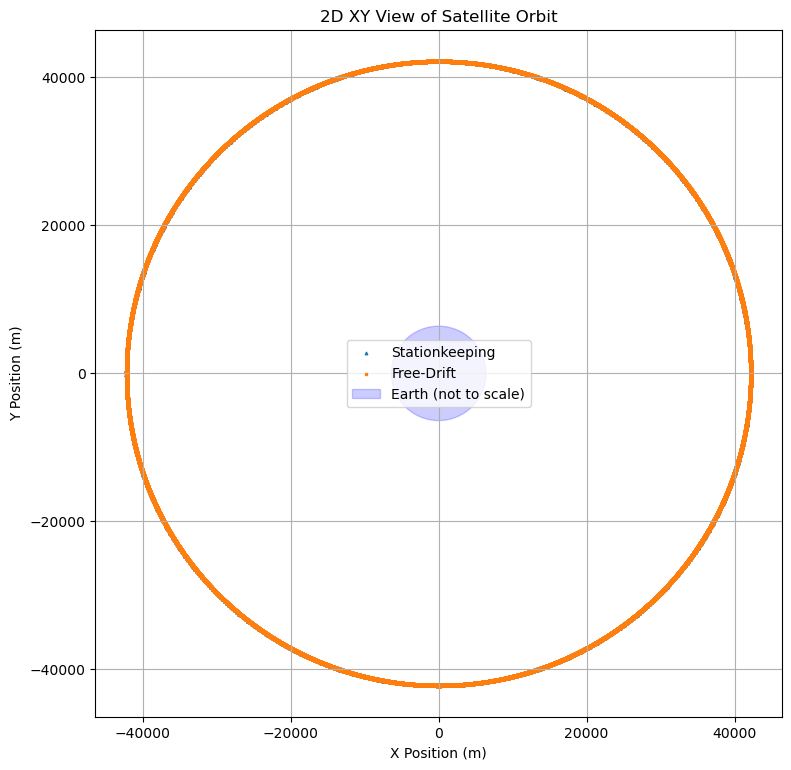

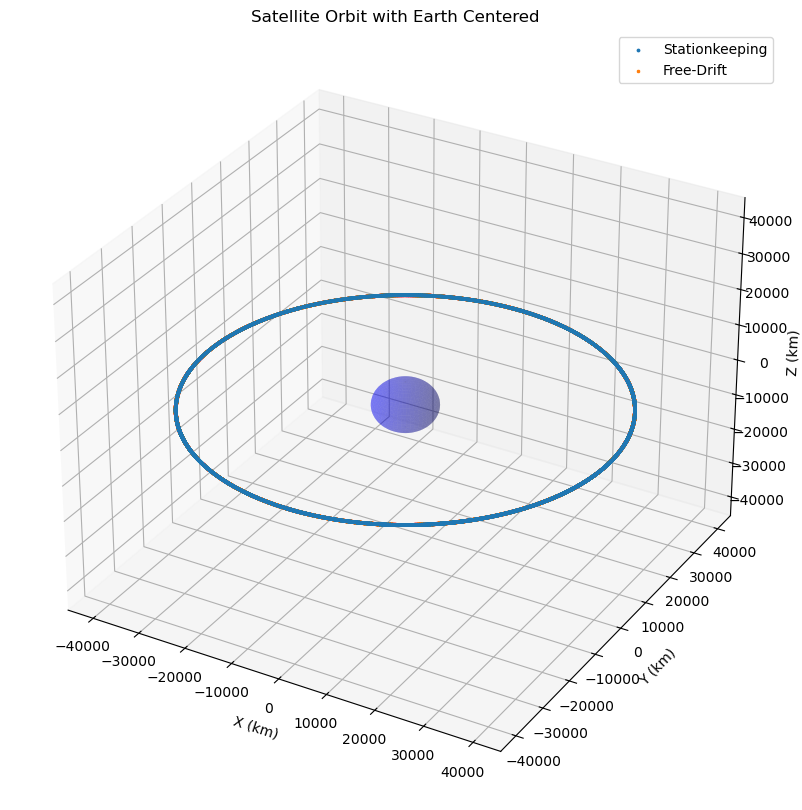

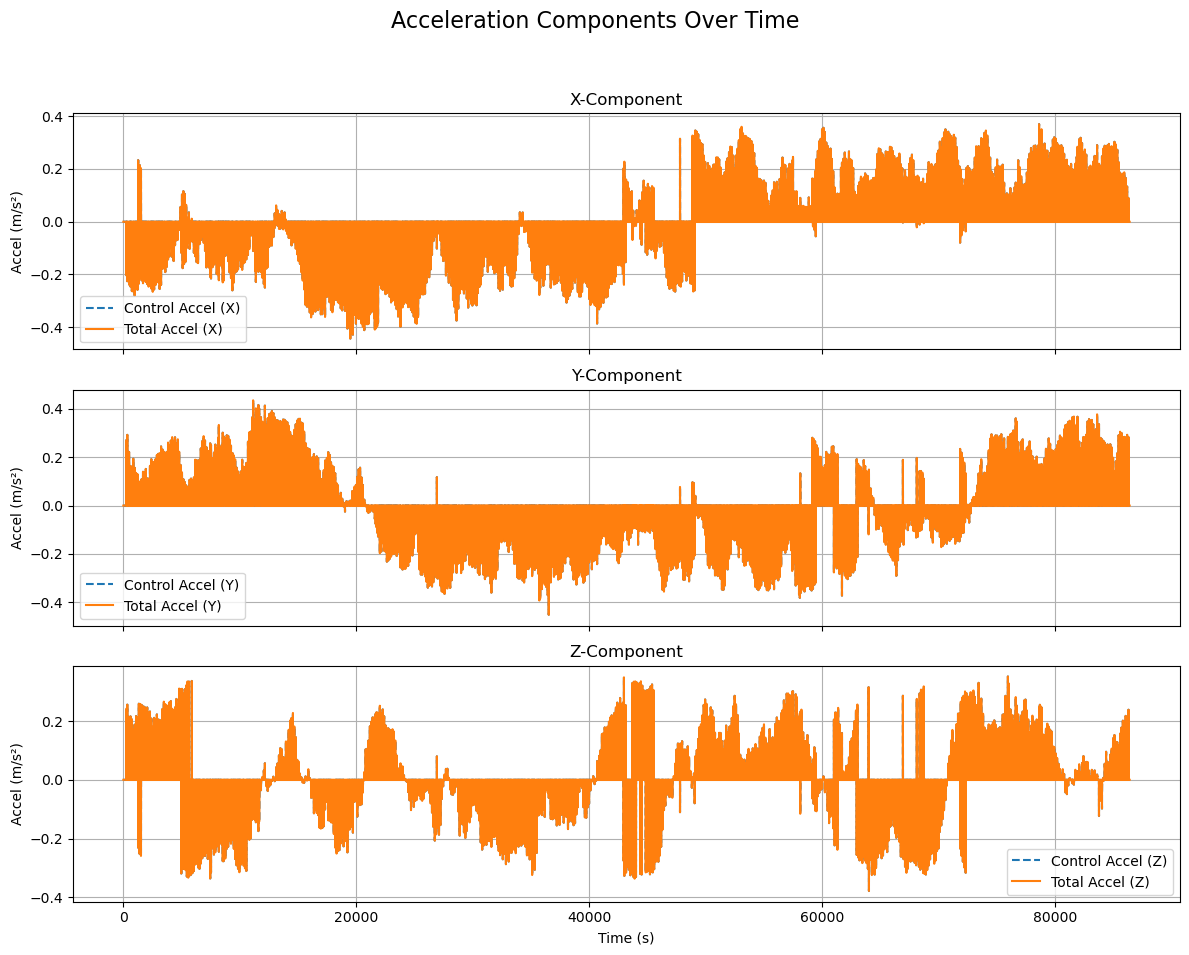

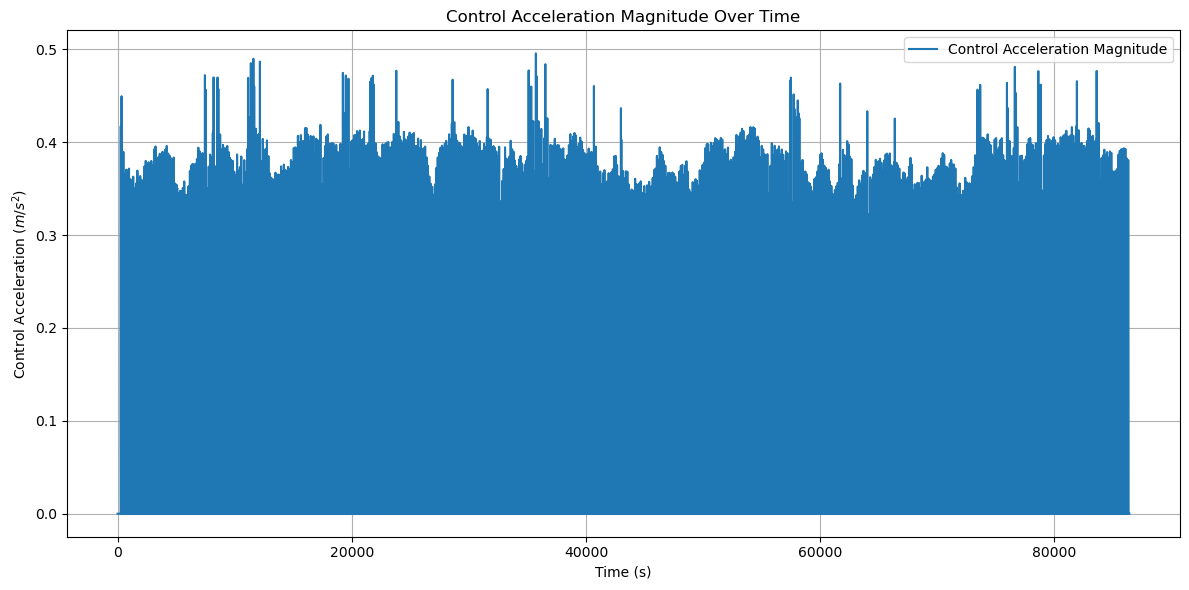

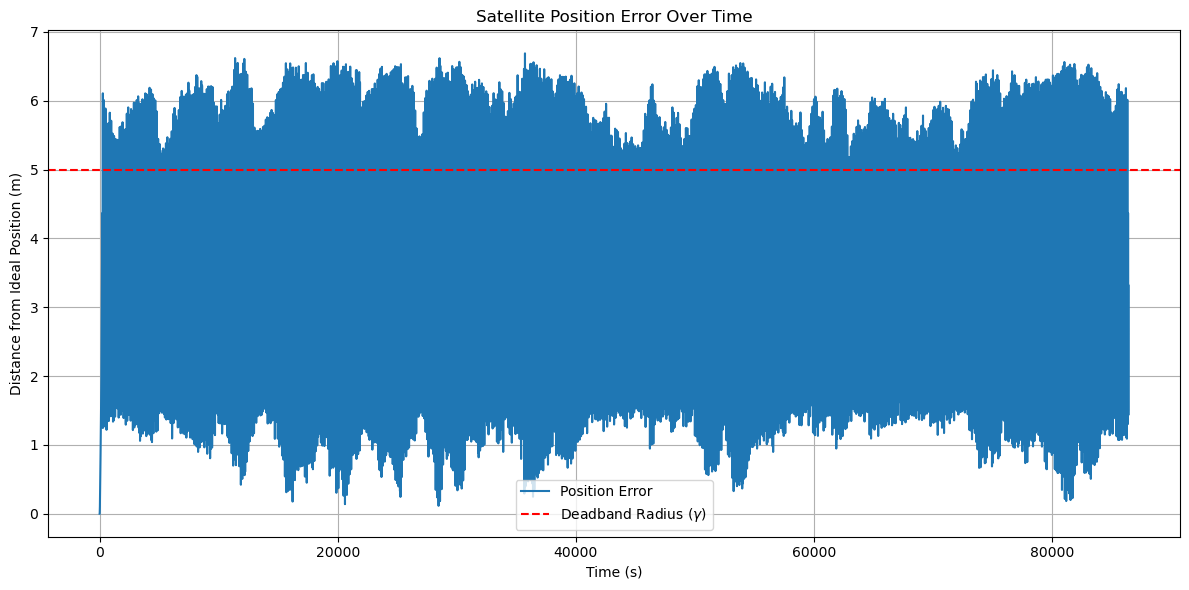

In [9]:
df = run_full_simulation()

In [10]:
df

,Time (s),Satellite ID,Longitude (deg),X (km),Y (km),Z (km),VX (km/s),VY (km/s),VZ (km/s),ideal X (km),...,ideal VX (km/s),ideal VY (km/s),ideal VZ (km/s),Status,Control Accel (X),Control Accel (Y),Control Accel (Z),Total Accel (X),Total Accel (Y),Total Accel (Z)
0,0.0,Geosat-1,0.000000,42164.137000,0.000000,0.000000,0.000000,3.074661,0.000000,42164.137000,...,0.000000,3.074661,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-4.148394e-09,-2.168510e-09
1,1.0,Geosat-1,0.004179,42164.136707,3.075096,-0.000463,-0.000586,3.075531,-0.000926,42164.136888,...,-0.000224,3.074661,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-2.050035e-08,-2.165576e-09
2,2.0,Geosat-1,0.008357,42164.136234,6.150009,-0.001164,-0.000361,3.074295,-0.000475,42164.136552,...,-0.000448,3.074661,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-3.685133e-08,-2.161378e-09
3,3.0,Geosat-1,0.012535,42164.136374,9.224499,-0.001186,0.000640,3.074686,0.000430,42164.135991,...,-0.000673,3.074661,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-5.320007e-08,-2.160787e-09
4,4.0,Geosat-1,0.016712,42164.136645,12.298323,-0.000450,-0.000098,3.072962,0.001042,42164.135206,...,-0.000897,3.074661,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-6.954525e-08,-2.164230e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,86395.0,Geosat-1,0.961747,42158.001877,707.716193,-0.891742,-0.086005,2.965123,-0.141667,42158.154756,...,-0.051792,3.074225,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-3.769364e-06,1.689739e-09
86396,86396.0,Geosat-1,0.965777,42157.916312,710.680930,-1.032804,-0.085126,2.964352,-0.140459,42158.102853,...,-0.052016,3.074221,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-3.785139e-06,2.440384e-09
86397,86397.0,Geosat-1,0.969806,42157.831300,713.644772,-1.171969,-0.084897,2.963333,-0.137871,42158.050725,...,-0.052240,3.074217,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-3.800909e-06,3.180939e-09
86398,86398.0,Geosat-1,0.973835,42157.745881,716.608658,-1.310141,-0.085941,2.964440,-0.138472,42157.998372,...,-0.052464,3.074214,0.0,non-stationkeeping,0.0,0.0,0.0,-0.000224,-3.816680e-06,3.916216e-09


In [16]:
0.02*0.02



0.0004